# WEIGHTED ENSEMBLE

In [23]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
# Thêm thư mục gốc vào path
from sklearn.model_selection import cross_val_predict, KFold
project_root = Path.cwd().parent
sys.path.append(str(project_root))
import warnings
warnings.filterwarnings("ignore")

from src.utils import load_data, save_model, save_metrics, evaluate, save_figure

# Chuyển CWD về thư mục gốc (nếu đang trong notebooks/)
try:
    if Path(os.getcwd()).name == 'notebooks':
        os.chdir('..')
except:
    pass


# CLASS WeightedEnsemble

In [24]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        # clone từng model để tránh ghi đè model load từ .pkl
        self.models_ = [clone(m) for m in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        preds = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(preds, axis=1)


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        X_arr = np.array(X)
        y_arr = np.array(y)

        out_of_fold_predictions = np.zeros((X_arr.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_idx, holdout_idx in kfold.split(X_arr, y_arr):
                instance = clone(model)
                self.base_models_[i].append(instance)

                instance.fit(X_arr[train_idx], y_arr[train_idx])

                y_pred = instance.predict(X_arr[holdout_idx])
                out_of_fold_predictions[holdout_idx, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y_arr)
        return self
    
    def predict(self, X):
        X_arr = np.array(X)

        meta_features = np.column_stack([
            np.column_stack([model.predict(X_arr) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])

        return self.meta_model_.predict(meta_features)

    
class WeightedEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    def fit(self, X, y):
        return self  # models đã được huấn luyện từ trước
    
    def predict(self, X):
        X_arr = np.array(X) if hasattr(X, 'values') else X
        
        preds = [m.predict(X_arr) for m in self.models]
        weighted_pred = np.average(np.column_stack(preds), axis=1, weights=self.weights)
        return weighted_pred


# 1. LOAD DATA AND MODEL 

In [25]:
# Load data
X, y = load_data()
print(f"Data loaded. Shape: {X.shape}")

# Load models đã lưu
models = {}
model_paths = {
    'stacking': 'models/stacking_ensemble.pkl',
    'lightgbm': 'models/lightgbm.pkl',
    'averaging': 'models/averaging.pkl'
}

for name, path in model_paths.items():
    try:
        models[name] = joblib.load(path)     
        print(f" Đã load {name}")
    except FileNotFoundError:
        print(f" Không tìm thấy {path}")

if len(models) < 3:
    print(" Thiếu model thành phần. Kết quả Ensemble có thể không tối ưu.")


Data loaded. Shape: (1458, 338)
 Đã load stacking
 Đã load lightgbm
 Đã load averaging


# 2. LẤY DỰ ĐOÁN RIÊNG LẺ 

In [26]:
preds_dict = {}

X_arr = np.array(X) if hasattr(X, 'values') else X

for name, model in models.items():
    print(f"Dự đoán với {name}...")
    preds = model.predict(X_arr)
    preds_dict[name] = preds

    rmse = np.sqrt(np.mean((y - preds)**2))
    print(f"  -> RMSE riêng của {name}: {rmse:.4f}")


Dự đoán với stacking...
  -> RMSE riêng của stacking: 0.0712
Dự đoán với lightgbm...
  -> RMSE riêng của lightgbm: 0.0645
Dự đoán với averaging...
  -> RMSE riêng của averaging: 0.0618


# 3. TỐI ƯU TRỌNG SỐ ENSEMBLE 

In [27]:
print("-" * 66)
print("\t      Đang tạo dự đoán OOF để tối ưu trọng số")
print("-" * 66)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lấy dự đoán OOF cho từng mô hình
oof_preds = {}
for name, model in models.items():
    print(f"  Đang chạy Cross-val cho {name}...")
    # Dùng clone để đảm bảo model sạch, chưa học gì từ X, y
    oof_preds[name] = cross_val_predict(clone(model), X, y, cv=kf)

# Tạo ma trận dự đoán từ kết quả OOF 
pred_matrix_oof = np.column_stack([
    oof_preds['stacking'],
    oof_preds['averaging'],
    oof_preds['lightgbm']
])

# Hàm loss tính trên OOF
def loss_func(weights):
    # Đảm bảo trọng số tổng = 1
    w = weights / np.sum(weights)
    final_pred = np.average(pred_matrix_oof, axis=1, weights=w)
    return np.sqrt(np.mean((y - final_pred)**2))

# Tối ưu hóa
init_weights = [0.4, 0.3, 0.3] 
bounds = [(0, 1)] * 3
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})

res = minimize(loss_func, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)

best_weights = res.x
print("-" * 66)
print("\t\tTỐI ƯU HOÀN TẤT")
print("-" * 66)
print(f"Stacking Weight : {best_weights[0]:.4f}")
print(f"Averaging Weight: {best_weights[1]:.4f}")
print(f"LightGBM Weight : {best_weights[2]:.4f}")
print(f"OOF RMSE : {res.fun:.4f}")

# Sau khi có trọng số tốt nhất, tạo mô hình Weighted Ensemble trên toàn bộ dữ liệu
weighted_ensemble = WeightedEnsemble([models['stacking'], models['averaging'], models['lightgbm']], best_weights)

------------------------------------------------------------------
	      Đang tạo dự đoán OOF để tối ưu trọng số
------------------------------------------------------------------
  Đang chạy Cross-val cho stacking...
  Đang chạy Cross-val cho lightgbm...
  Đang chạy Cross-val cho averaging...
------------------------------------------------------------------
		TỐI ƯU HOÀN TẤT
------------------------------------------------------------------
Stacking Weight : 0.5982
Averaging Weight: 0.4018
LightGBM Weight : 0.0000
OOF RMSE : 0.1131


# 4. ĐÁNH GIÁ

In [32]:
# Khởi tạo ensemble cuối cùng
weighted_models_list = [models['stacking'], models['averaging'], models['lightgbm']]
weighted_ensemble = WeightedEnsemble(weighted_models_list, best_weights)

# Predict
weighted_oof_pred = np.average(pred_matrix_oof, axis=1, weights=best_weights)
metrics_oof = evaluate(y, weighted_oof_pred)

print("\n WEIGHTED ENSEMBLE Metrics (OOF):")
for k, v in metrics_oof.items():
    print(f"  - {k.upper()}: {v:.4f}")

save_metrics('weighted_ensemble', metrics_oof)



 WEIGHTED ENSEMBLE Metrics (OOF):
  - RMSE: 0.1131
  - MAE: 0.0768
  - R2: 0.9198


# 5. TRỰC QUAN HOÁ KẾT QUẢ 

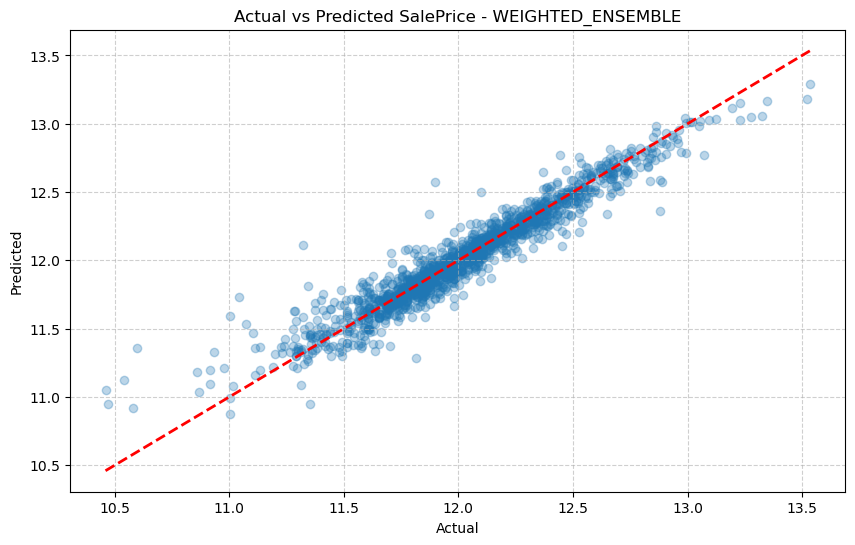

Hình ảnh đã lưu thành công tại: results/figures/weighted_ensemble_actual_vs_predicted.png


In [33]:
filename_to_save = 'weighted_ensemble_actual_vs_predicted.png' 
figure_path = f'results/figures/{filename_to_save}' 

fig, ax = plt.subplots(figsize=(10, 6)) 
model_name = 'weighted_ensemble'
ax.scatter(y, weighted_oof_pred, alpha=0.3)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title(f'Actual vs Predicted SalePrice - {model_name.upper()}')
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()
save_figure(fig, filename=filename_to_save) 



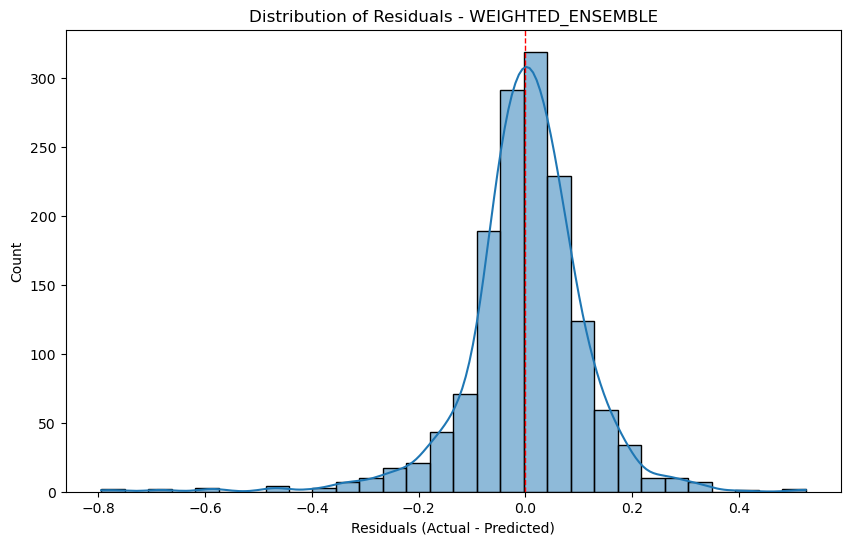

Hình ảnh đã lưu thành công tại: results/figures/weighted_ensemble_actual_vs_predicted.png


In [34]:
residuals = y - weighted_oof_pred
figure_path_res = 'results/figures/weighted_ensemble_residuals.png'

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title(f'Distribution of Residuals - {model_name.upper()}')
plt.savefig(figure_path_res)
plt.show()

save_figure(fig, filename=filename_to_save) 

# 6. LƯU MODEL 

In [35]:
model_name = 'weighted_ensemble'
save_model(weighted_ensemble, 'weighted_ensemble')
print(f"Mô hình {model_name} đã được lưu thành công tại models/{model_name}.pkl")

Mô hình weighted_ensemble đã được lưu thành công tại models/weighted_ensemble.pkl
